**<span style="color: #808080;">In The Name of God</span>**

---

# <span style="color: #20B2AA;">Assignment 2</span>




In [43]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

## Data Ingestion Layer

***run the kafka.py***

## Batch Processing Layer

read the transaction data as json

In [44]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Daroo").getOrCreate()

df = spark.read.json('content/validated_transactions.json')
df.show()

25/04/27 10:20:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------+-----------------+---------------+-----------+-------------+--------------------+--------------+------------------+------------------+-----------------+-----------+--------------+----------+--------+--------------------+------------+--------------------+----------+
| amount|commission_amount|commission_type|customer_id|customer_type|         device_info|failure_reason|               lat|               lng|merchant_category|merchant_id|payment_method|risk_level|  status|           timestamp|total_amount|      transaction_id|vat_amount|
+-------+-----------------+---------------+-----------+-------------+--------------------+--------------+------------------+------------------+-----------------+-----------+--------------+----------+--------+--------------------+------------+--------------------+----------+
|1100758|            22015|           flat|   cust_548|  CIfunctionP|  {NULL, NULL, NULL}|     cancelled|35.687032407925614|  51.3104264455149|     food_service|   merch_15|  

Commission Analysis Batch Job

In [45]:
from pyspark.sql.functions import sum, avg, count, col, when


filtered_df = df.filter(df["status"] == "approved")

commission_analysis_df = filtered_df.select(
    "transaction_id",
    "commission_type",
    "merchant_category",
    "commission_amount",
    "total_amount",
    "amount"
)


commission_analysis_df = commission_analysis_df.groupBy("merchant_category").agg(
    sum("commission_amount").alias("total_commission"),
    avg("commission_amount").alias("avg_commission"),
    count("*").alias("transaction_count"),
    sum("amount").alias("total_transaction_amount"),
    count(when(col("commission_type") == "flat", 1)).alias("flat_count"),
    count(when(col("commission_type") == "progressive", 1)).alias("progressive_count"),
    count(when(col("commission_type") == "tiered", 1)).alias("tiered_count"),
)

commission_analysis_df = commission_analysis_df.withColumn(
    "commission_to_transaction_ratio", 
    col("total_commission") / col("total_transaction_amount")
)
commission_analysis_df.show()

+-----------------+----------------+------------------+-----------------+------------------------+----------+-----------------+------------+-------------------------------+
|merchant_category|total_commission|    avg_commission|transaction_count|total_transaction_amount|flat_count|progressive_count|tiered_count|commission_to_transaction_ratio|
+-----------------+----------------+------------------+-----------------+------------------------+----------+-----------------+------------+-------------------------------+
|           retail|        14393166| 20358.08486562942|              707|               719675369|       215|              238|         254|            0.01999952564723665|
|    entertainment|        13750770|20961.539634146342|              656|               687554369|       213|              216|         227|           0.019999538392868537|
|     food_service|        14941435|20439.719562243503|              731|               747089870|       233|              246|        

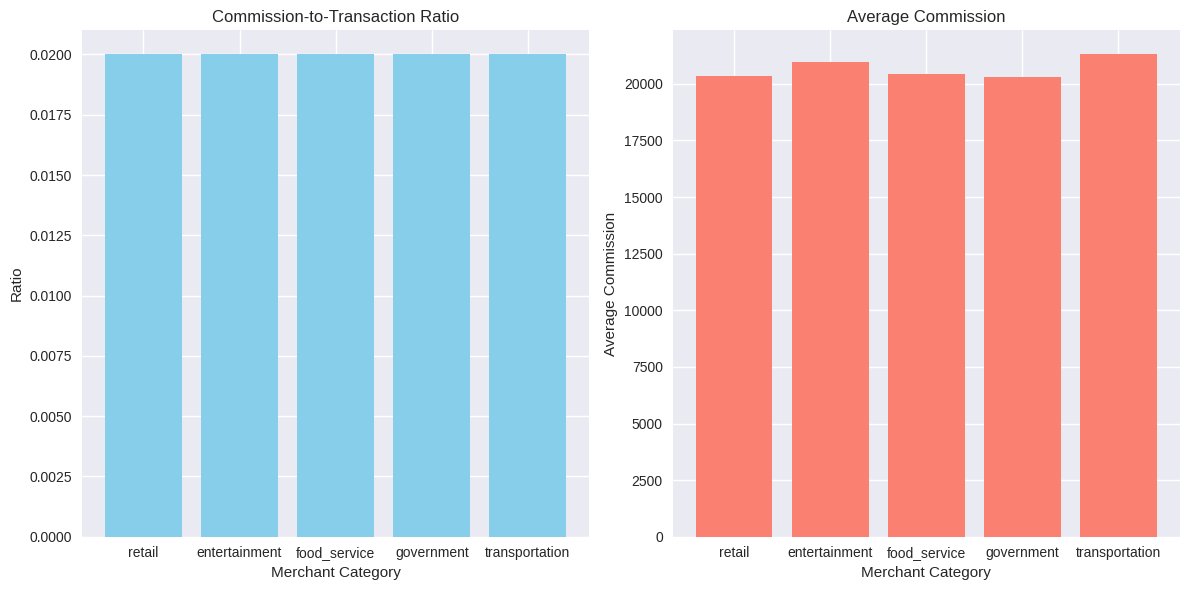

In [46]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8')

data = commission_analysis_df.select(
    "merchant_category", 
    "commission_to_transaction_ratio", 
    "avg_commission"
).collect()

categories = [row["merchant_category"] for row in data]
ratios = [row["commission_to_transaction_ratio"] for row in data]
avgs = [row["avg_commission"] for row in data]

x = np.arange(len(categories))

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False)

axes[0].bar(categories, ratios, color='skyblue')
axes[0].set_title("Commission-to-Transaction Ratio")
axes[0].set_xlabel("Merchant Category")
axes[0].set_ylabel("Ratio")
axes[0].tick_params(axis='x')

axes[1].bar(categories, avgs, color='salmon')
axes[1].set_title("Average Commission")
axes[1].set_xlabel("Merchant Category")
axes[1].set_ylabel("Average Commission")
axes[1].tick_params(axis='x')

plt.tight_layout()
plt.show()


# <span style="color: #20B2AA;">Transaction Pattern Analysis </span>


## <span style="color: #99CCFF;">Part I</span>

In [ ]:
from pyspark.sql.functions import hour, count, minute

filtered_df = filtered_df.withColumn("hour", hour(col("timestamp")))

temporal_pattern_df = filtered_df.groupBy("hour").agg(
    count("*").alias("transaction_count")
)

temporal_pattern_df.sort(col("transaction_count").desc()).show()


PySparkTypeError: [NOT_COLUMN_OR_STR] Argument `col` should be a Column or str, got method.

## <span style="color: #99CCFF;">Part II</span>

In [48]:
peak_time_df = temporal_pattern_df.orderBy(col("transaction_count").desc())
peak_time_df.show(1)

+----+-----------------+
|hour|transaction_count|
+----+-----------------+
|  22|              859|
+----+-----------------+
only showing top 1 row



## <span style="color: #99CCFF;">Part III</span>

In [49]:
customer_segment_df = filtered_df.groupBy("customer_id").agg(
    count("*").alias("transaction_count"),
    sum("amount").alias("total_spent")
)
customer_segment_df.sort(col("total_spent").desc()).show()

+-----------+-----------------+-----------+
|customer_id|transaction_count|total_spent|
+-----------+-----------------+-----------+
|   cust_180|                9|   13539868|
|   cust_285|               10|   12297314|
|   cust_999|               11|   11900112|
|   cust_961|                9|   11473138|
|    cust_82|                9|   11130449|
|   cust_627|                8|    9907902|
|   cust_792|                6|    9854112|
|    cust_30|                7|    9591743|
|   cust_387|                7|    9589803|
|   cust_332|                8|    9575757|
|   cust_237|                7|    9550146|
|   cust_978|                6|    9544146|
|   cust_748|                8|    9536095|
|   cust_880|                8|    9423083|
|    cust_53|                6|    9421791|
|   cust_720|                6|    9327831|
|   cust_412|                6|    9228689|
|   cust_606|                6|    9168621|
|   cust_142|                8|    8978790|
|   cust_130|                8| 

## <span style="color: #99CCFF;">Part IV</span>

In [50]:
merchant_behavior_df = filtered_df.groupBy("merchant_category").agg(
    count("*").alias("transaction_count"),
    sum("amount").alias("total_sales")
)

merchant_behavior_df.sort(col("transaction_count").desc()).show()

+-----------------+-----------------+-----------+
|merchant_category|transaction_count|total_sales|
+-----------------+-----------------+-----------+
|     food_service|              731|  747089870|
|           retail|              707|  719675369|
|   transportation|              683|  727411794|
|       government|              675|  684959707|
|    entertainment|              656|  687554369|
+-----------------+-----------------+-----------+



## <span style="color: #99CCFF;">Part V</span>

In [51]:
from pyspark.sql.functions import when

filtered_df = filtered_df.withColumn(
    "time_of_day",
    when((col("hour") >= 6) & (col("hour") < 12), "Morning")
    .when((col("hour") >= 12) & (col("hour") < 18), "Afternoon")
    .when((col("hour") >= 18) & (col("hour") < 24), "Evening")
    .otherwise("Night")
)

time_of_day_df = filtered_df.groupBy("time_of_day").agg(
    count("*").alias("transaction_count")
)

time_of_day_df.show()


+-----------+-----------------+
|time_of_day|transaction_count|
+-----------+-----------------+
|    Evening|             1435|
|    Morning|              722|
|  Afternoon|              663|
|      Night|              632|
+-----------+-----------------+



## <span style="color: #99CCFF;">Part VI</span>

In [52]:

filtered_df = filtered_df.withColumn("hour", hour(col("timestamp")))
filtered_df = filtered_df.withColumn("minute", minute(col("timestamp")))

spending_trend_df = filtered_df.groupBy("hour", "minute").agg(
    sum("amount").alias("total_spent")
).orderBy("hour", "minute")

spending_trend_df.sort(col("total_spent").desc()).show()


+----+------+-----------+
|hour|minute|total_spent|
+----+------+-----------+
|  22|    47|  109699571|
|  22|    45|   93205279|
|  22|    40|   92514833|
|  22|    44|   91387829|
|  22|    46|   89261477|
|  22|    41|   85281604|
|  22|    42|   83701446|
|  22|    43|   75581651|
|  22|    48|   74666009|
|  22|     2|    9242870|
|   7|    33|    8160004|
|  16|    24|    7893397|
|  10|    31|    7744145|
|   2|    49|    7415993|
|  13|     5|    7385463|
|  15|    28|    7002781|
|   1|     2|    6851591|
|  13|    40|    6829057|
|  21|     4|    6796691|
|   9|    11|    6664873|
+----+------+-----------+
only showing top 20 rows



# <span style="color: #20B2AA;">Data Storage Implementation</span>


In [ ]:
from pymongo import MongoClient
from datetime import datetime

client = MongoClient("mongodb://localhost:27017/")
db = client['daroogheDB']
transactions_collection = db['transactions']

rows = df.collect()

documents = []
for row in rows:
    transaction = {
        "id": row['transaction_id'],
        "date": row['timestamp'],
        "customer_id": row['customer_id'],
        "merchant_id": row['merchant_id'],
        "lat": row['lat'],
        "long": row['lng'],
        "merchant_category": row['merchant_category'],
        "amount": row['amount'],
        "vat_amount": row['vat_amount'],
        "commission_type": row["commission_type"],
        "commission_amount": row["commission_amount"],
        "total_amount": row["total_amount"],
        "customer_type": row["customer_type"],
        "risk_level": row["risk_level"],
        "failure_reason": row["failure_reason"],
        "device_info": row["device_info"],
        "payment_method": row["payment_method"],
        "status": row["status"],
        "createdAt": datetime.utcnow()
    }
    documents.append(transaction)

if documents:
    transactions_collection.insert_many(documents)
